## **Libraries**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor


## **Dataset Load and Cleaning**

In [2]:
df = pd.read_csv('../dataset/ecommerce_customer_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             250000 non-null  int64  
 1   Customer ID            250000 non-null  int64  
 2   Purchase Date          250000 non-null  object 
 3   Product Category       250000 non-null  object 
 4   Product Price          225000 non-null  float64
 5   Quantity               225000 non-null  float64
 6   Total Purchase Amount  202461 non-null  float64
 7   Payment Method         225000 non-null  object 
 8   Customer Age           225000 non-null  float64
 9   Returns                202618 non-null  float64
 10  Customer Name          250000 non-null  object 
 11  Age                    250000 non-null  int64  
 12  Gender                 225000 non-null  object 
 13  Churn                  250000 non-null  int64  
dtypes: float64(5), int64(4), object(5)
m

In [3]:
df.head()

,Unnamed: 0,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,0,44605,3/05/2023 21:30,Home,177.0,1.0,177.0,PayPal,31.0,1.0,John Rivera,31,Female,0
1,1,44605,16/05/2021 13:57,Electronics,174.0,3.0,522.0,NaN,31.0,1.0,John Rivera,31,Female,0
2,2,44605,13/07/2020 6:16,Books,413.0,1.0,413.0,Credit Card,NaN,1.0,John Rivera,31,Female,0
3,3,44605,17/01/2023 13:14,Electronics,396.0,3.0,1188.0,Cash,31.0,0.0,John Rivera,31,Female,0
4,4,44605,1/05/2021 11:29,Books,259.0,4.0,1036.0,PayPal,31.0,1.0,John Rivera,31,Female,0


In [4]:
df_cleaned = df.dropna().copy()
df_cleaned = df_cleaned.drop(columns=['Unnamed: 0', 'Customer ID', 'Churn','Returns', 'Customer Age', 'Customer Name'])
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119819 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Purchase Date          119819 non-null  object 
 1   Product Category       119819 non-null  object 
 2   Product Price          119819 non-null  float64
 3   Quantity               119819 non-null  float64
 4   Total Purchase Amount  119819 non-null  float64
 5   Payment Method         119819 non-null  object 
 6   Age                    119819 non-null  int64  
 7   Gender                 119819 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 8.2+ MB


In [5]:
df_cleaned['Purchase Date'] = pd.to_datetime(df_cleaned['Purchase Date'], dayfirst=True)
df_cleaned.head()

,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Age,Gender
0,2023-05-03 21:30:00,Home,177.0,1.0,177.0,PayPal,31,Female
3,2023-01-17 13:14:00,Electronics,396.0,3.0,1188.0,Cash,31,Female
4,2021-05-01 11:29:00,Books,259.0,4.0,1036.0,PayPal,31,Female
5,2022-08-25 06:48:00,Home,191.0,3.0,573.0,Credit Card,27,Female
13,2021-12-20 23:44:00,Electronics,428.0,4.0,1712.0,Cash,27,Male


## **EDA for Dataset**

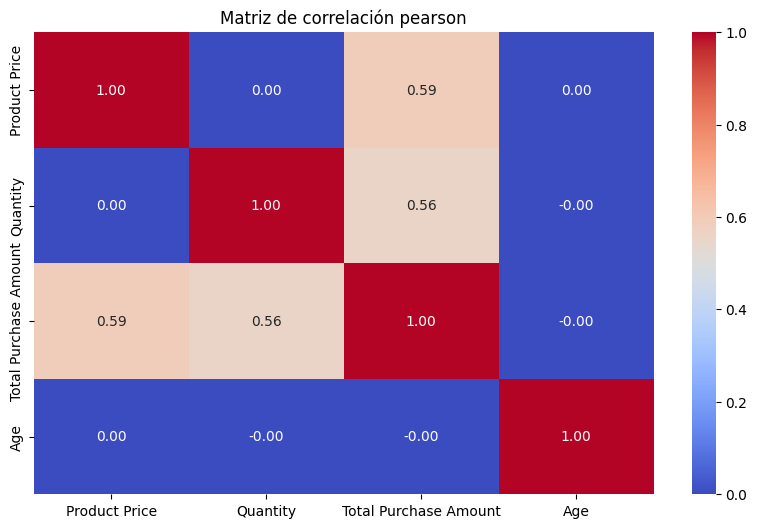

In [6]:
df_numeric = df_cleaned.select_dtypes(include=['number'])

correlation_matrix_pearson = df_numeric.corr(method='pearson')
correlation_matrix_spearman = df_numeric.corr(method='spearman')

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_pearson, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación pearson")
plt.show()

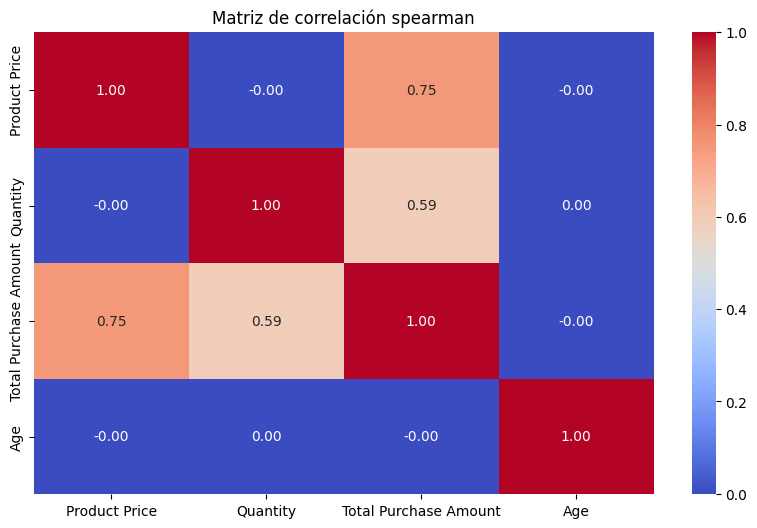

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación spearman")
plt.show()

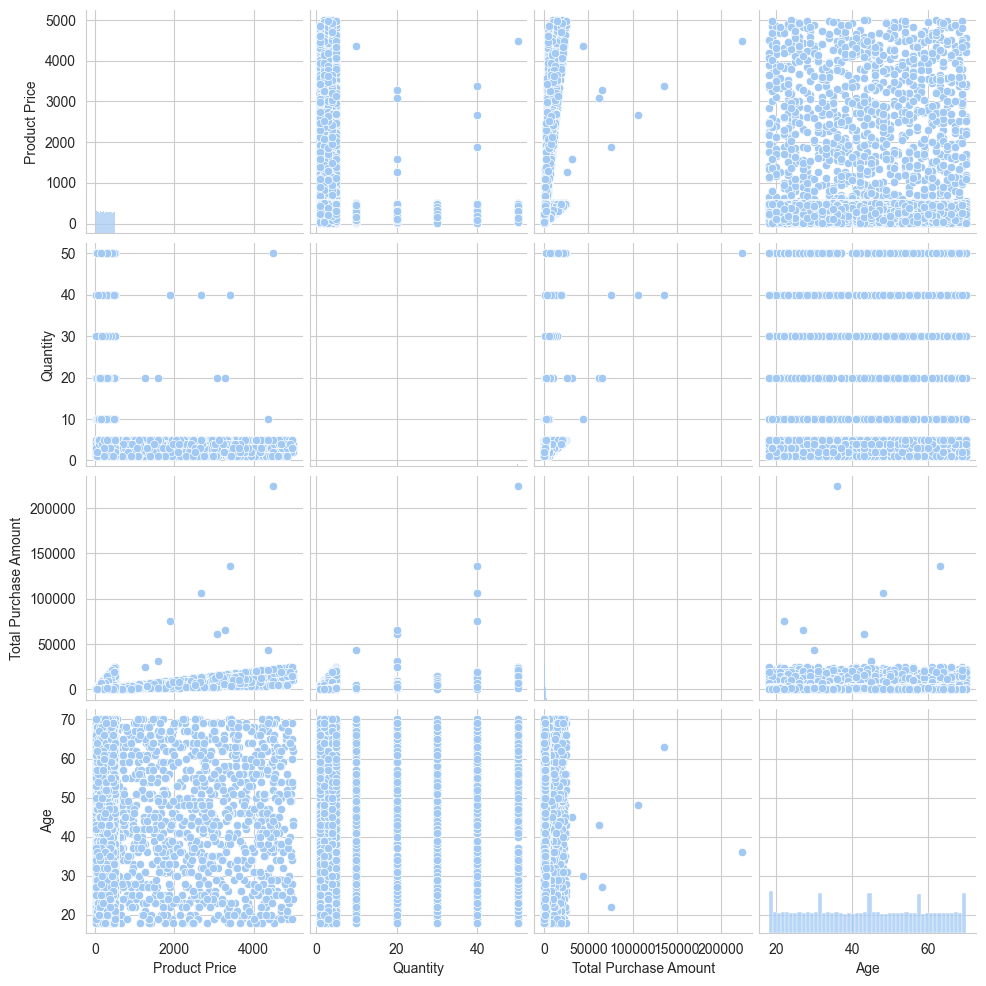

In [8]:
sns.set_palette("pastel")
sns.set_style("whitegrid")
sns.pairplot(df_cleaned)

In [9]:
df_cleaned['purchase_month'] = df_cleaned['Purchase Date'].dt.month
df_cleaned['purchase_weekday'] = df_cleaned['Purchase Date'].dt.weekday
df_cleaned['purchase_hour'] = df_cleaned['Purchase Date'].dt.hour
df_cleaned = df_cleaned.drop(['Purchase Date'], axis=1)

In [10]:
df_onehot = pd.get_dummies(df_cleaned, columns=['Payment Method', 'Product Category','Gender'],drop_first=True)
df_onehot.head()

,Product Price,Quantity,Total Purchase Amount,Age,purchase_month,purchase_weekday,purchase_hour,Payment Method_Credit Card,Payment Method_PayPal,Product Category_Clothing,Product Category_Electronics,Product Category_Home,Gender_Male
0,177.0,1.0,177.0,31,5,2,21,False,True,False,False,True,False
3,396.0,3.0,1188.0,31,1,1,13,False,False,False,True,False,False
4,259.0,4.0,1036.0,31,5,5,11,False,True,False,False,False,False
5,191.0,3.0,573.0,27,8,3,6,True,False,False,False,True,False
13,428.0,4.0,1712.0,27,12,0,23,False,False,False,True,False,True


In [11]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119819 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Product Price                 119819 non-null  float64
 1   Quantity                      119819 non-null  float64
 2   Total Purchase Amount         119819 non-null  float64
 3   Age                           119819 non-null  int64  
 4   purchase_month                119819 non-null  int32  
 5   purchase_weekday              119819 non-null  int32  
 6   purchase_hour                 119819 non-null  int32  
 7   Payment Method_Credit Card    119819 non-null  bool   
 8   Payment Method_PayPal         119819 non-null  bool   
 9   Product Category_Clothing     119819 non-null  bool   
 10  Product Category_Electronics  119819 non-null  bool   
 11  Product Category_Home         119819 non-null  bool   
 12  Gender_Male                   119819 non-null  bo

In [12]:
df_onehot.head()

,Product Price,Quantity,Total Purchase Amount,Age,purchase_month,purchase_weekday,purchase_hour,Payment Method_Credit Card,Payment Method_PayPal,Product Category_Clothing,Product Category_Electronics,Product Category_Home,Gender_Male
0,177.0,1.0,177.0,31,5,2,21,False,True,False,False,True,False
3,396.0,3.0,1188.0,31,1,1,13,False,False,False,True,False,False
4,259.0,4.0,1036.0,31,5,5,11,False,True,False,False,False,False
5,191.0,3.0,573.0,27,8,3,6,True,False,False,False,True,False
13,428.0,4.0,1712.0,27,12,0,23,False,False,False,True,False,True


## Prepare Train, Test, Val Data

In [13]:
scaler = StandardScaler()
df_scaled = df_onehot.copy()
num_cols = ['Product Price', 'Quantity', 'Age', 'purchase_month', 'purchase_weekday', 'purchase_hour','Total Purchase Amount']
df_scaled[num_cols] = pd.DataFrame(scaler.fit_transform(df_onehot[num_cols]), columns=num_cols, index=df_onehot.index)

In [14]:
df_scaled.head()

,Product Price,Quantity,Total Purchase Amount,Age,purchase_month,purchase_weekday,purchase_hour,Payment Method_Credit Card,Payment Method_PayPal,Product Category_Clothing,Product Category_Electronics,Product Category_Home,Gender_Male
0,-0.332778,-0.683265,-0.440667,-0.835381,-0.358961,-0.496821,1.373906,False,True,False,False,True,False
3,0.400882,-0.083230,0.170537,-0.835381,-1.551919,-0.996724,0.219201,False,False,False,True,False,False
4,-0.058074,0.216787,0.078645,-0.835381,-0.358961,1.002891,-0.069475,False,True,False,False,False,False
5,-0.285877,-0.083230,-0.201264,-1.095726,0.535758,0.003083,-0.791165,True,False,False,False,True,False
13,0.508083,0.216787,0.487324,-1.095726,1.728716,-1.496628,1.662582,False,False,False,True,False,True


In [15]:
X = df_scaled.drop(columns=['Total Purchase Amount'])  # eliminar columnas que no usamos
y = df_scaled['Total Purchase Amount']

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119819 entries, 0 to 249999
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Product Price                 119819 non-null  float64
 1   Quantity                      119819 non-null  float64
 2   Age                           119819 non-null  float64
 3   purchase_month                119819 non-null  float64
 4   purchase_weekday              119819 non-null  float64
 5   purchase_hour                 119819 non-null  float64
 6   Payment Method_Credit Card    119819 non-null  bool   
 7   Payment Method_PayPal         119819 non-null  bool   
 8   Product Category_Clothing     119819 non-null  bool   
 9   Product Category_Electronics  119819 non-null  bool   
 10  Product Category_Home         119819 non-null  bool   
 11  Gender_Male                   119819 non-null  bool   
dtypes: bool(6), float64(6)
memory usage: 7.1 MB


In [17]:
y.info()

<class 'pandas.core.series.Series'>
Index: 119819 entries, 0 to 249999
Series name: Total Purchase Amount
Non-Null Count   Dtype  
--------------   -----  
119819 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95855 entries, 22044 to 95606
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Product Price                 95855 non-null  float64
 1   Quantity                      95855 non-null  float64
 2   Age                           95855 non-null  float64
 3   purchase_month                95855 non-null  float64
 4   purchase_weekday              95855 non-null  float64
 5   purchase_hour                 95855 non-null  float64
 6   Payment Method_Credit Card    95855 non-null  bool   
 7   Payment Method_PayPal         95855 non-null  bool   
 8   Product Category_Clothing     95855 non-null  bool   
 9   Product Category_Electronics  95855 non-null  bool   
 10  Product Category_Home         95855 non-null  bool   
 11  Gender_Male                   95855 non-null  bool   
dtypes: bool(6), float64(6)
memory usage: 5.7 MB


## RandomForestRegressor 

In [20]:
# Define the base model
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid to try
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Create the GridSearch for regression
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # regression metric
    n_jobs=-1  # use all CPU cores
)

# Train and search for the best parameters
grid_search.fit(X_train, y_train)

# Best combination
print("Best hyperparameters:", grid_search.best_params_)

# Best CV score (neg MSE)
print("Best score (neg MSE):", grid_search.best_score_ * -1)

# Best model
best_rf = grid_search.best_estimator_

# Predict on test set
y_pred = best_rf.predict(X_test)


Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score (neg MSE): 0.243100037432481


In [21]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE on test set:", rmse)
print("R2 on test set:", r2)


RMSE on test set: 0.4397330009665453
R2 on test set: 0.8092969380868964


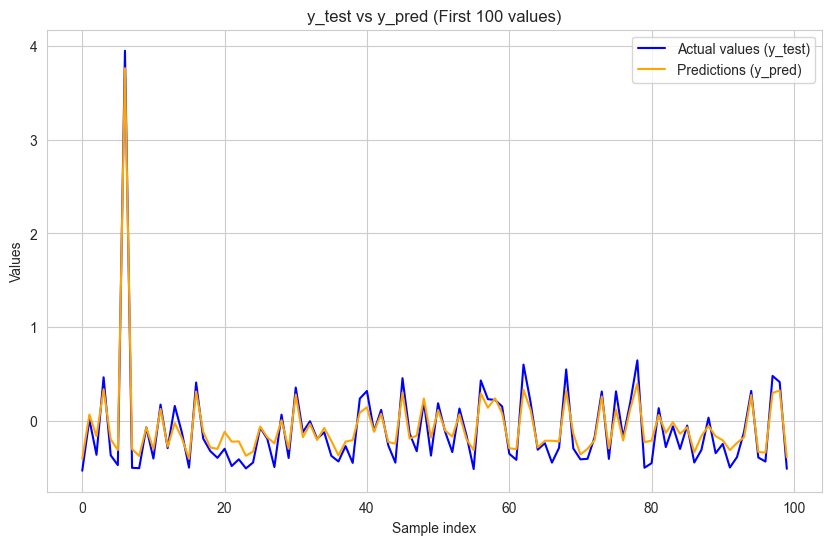

In [23]:
N = 100
x = range(N)
plt.figure(figsize=(10,6))
plt.plot(x[:N], y_test[:N], label='Actual values (y_test)', color='blue')
plt.plot(x[:N], y_pred[:N], label='Predictions (y_pred)', color='orange')
plt.xlabel('Sample index')
plt.ylabel('Values')
plt.title('y_test vs y_pred (First 100 values)')
plt.legend()
plt.show()

Save model

In [ ]:
joblib.dump(best_rf, 'random_forest_model.pkl')

## XGBRegressor

In [24]:
xgb_model = XGBRegressor(random_state=42)

# Hyperparameter grid to test
param_grid_xgb_model = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_xgb_model = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb_model,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # regression metric
    n_jobs=-1
)

# Fit the GridSearch to the training data
grid_search_xgb_model.fit(X_train, y_train)

# Best hyperparameter combination
print("Best hyperparameters:", grid_search_xgb_model.best_params_)

# Best score (negative MSE)
print("Best score (neg MSE):", grid_search_xgb_model.best_score_)

# Best model
best_xgb = grid_search_xgb_model.best_estimator_

# Predictions
y_pred_xgb_model = best_xgb.predict(X_test)

Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.6}
Best score (neg MSE): -0.10253207576120087


In [25]:
rmse_xgb_model = np.sqrt(mean_squared_error(y_test, y_pred_xgb_model))
r2_xgb_model = r2_score(y_test, y_pred_xgb_model)
print("RMSE on test set:", rmse_xgb_model)
print("R2 on test set:", r2_xgb_model)

RMSE on test set: 0.21965391346489327
R2 on test set: 0.952416384521542


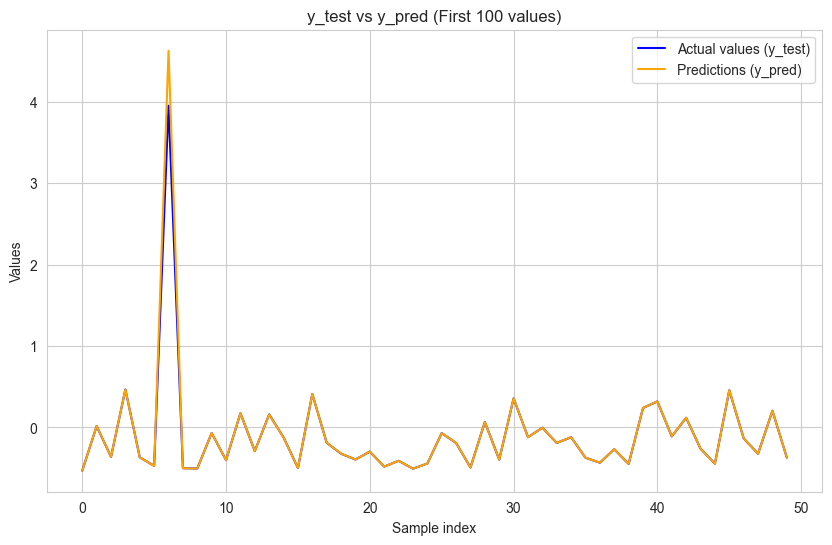

In [35]:
N = 50
x = range(N)
plt.figure(figsize=(10,6))
plt.plot(x[:N], y_test[:N], label='Actual values (y_test)', color='blue')
plt.plot(x[:N], y_pred_xgb_model[:N], label='Predictions (y_pred)', color='orange')
plt.xlabel('Sample index')
plt.ylabel('Values')
plt.title('y_test vs y_pred (First 100 values)')
plt.legend()
plt.show()

Save model

In [36]:
joblib.dump(best_xgb, "XGBRegressor_model.pkl")

['XGBRegressor_model.pkl']